# INF367 Mandatory 2

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
from src import Model1, Model2, Model3, circuit1, circuit2, circuit3

In [2]:
SEED = 367

## Data exploration and pre-processing

In [3]:
X, y = load_iris(return_X_y=True)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=.6, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, train_size=.5, random_state=SEED)
print("Training size: ", len(X_train))
print("Validation size: ", len(X_val))
print("Test size: ", len(X_test))

Training size:  90
Validation size:  30
Test size:  30


In [4]:
print("Features shape: ",X_train.shape)
print("Target shape: ",y_train.shape)
print(f"Feature value range: {np.min(X_train)} : {np.max(X_train)}")

Features shape:  (90, 4)
Target shape:  (90,)
Feature value range: 0.1 : 7.9


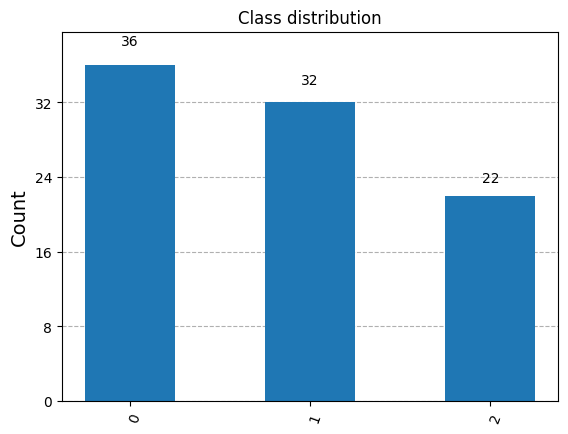

In [5]:
plot_histogram(Counter(y_train), title="Class distribution")

In [6]:
scaler = MinMaxScaler(feature_range=(0,np.pi))
X_train = scaler.fit_transform(X_train)

## QNN-circuits

In [7]:
_features = [0.4, 0.3, 0.1, 0.2] # Only for display purposes

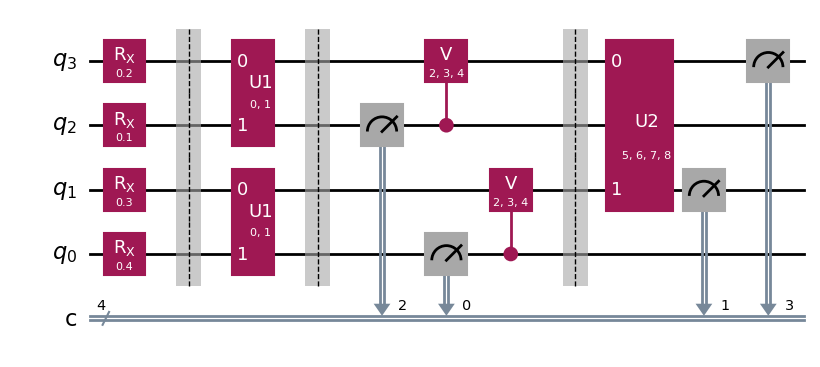

In [8]:
# Circuit 1
circ1 = circuit1(_features)
circ1.draw("mpl", reverse_bits=True, filename="images/circuit1.png")

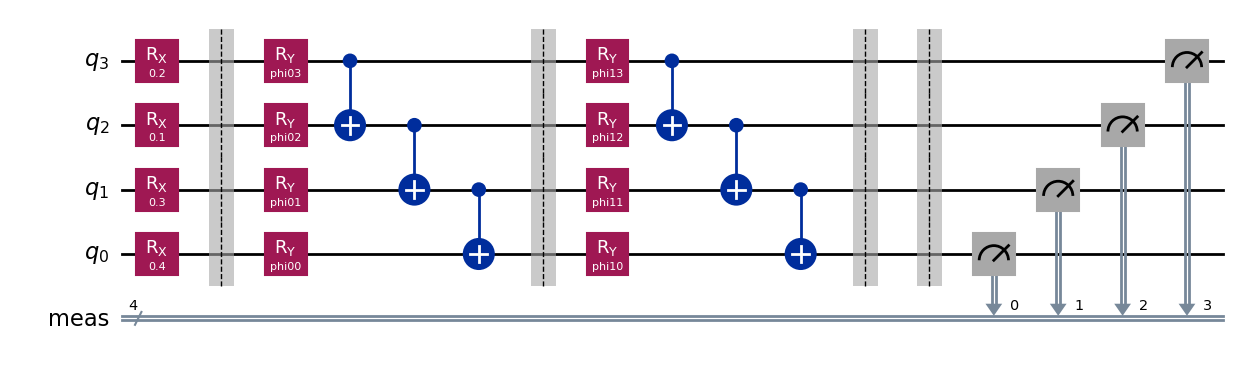

In [9]:
# Circuit 2
circ2 = circuit2(_features, layers=2)
circ2.draw("mpl", reverse_bits=True, filename="images/circuit2.png")

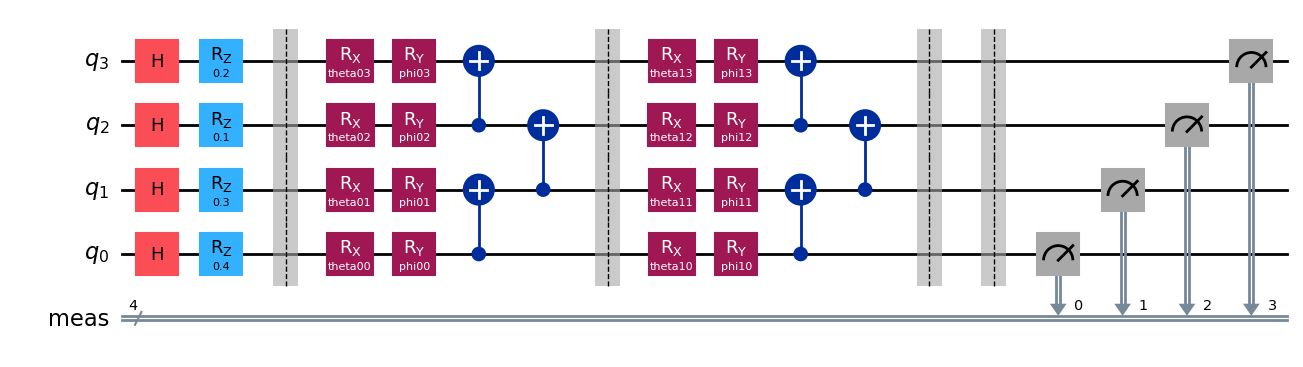

In [10]:
# Circuit 3
circ3 = circuit3(_features, layers=2)
circ3.draw("mpl", reverse_bits=True, filename="images/circuit3.png")

## Training and Validation

In [11]:
models = []
model_accuracies = []
n_samples = 4
lr_range = [0.1, 2] 
epsilon_range = [0.01, 1]
layers = [2, 6]
architectures = [Model1, Model2, Model3]

epochs = 20
for architecture in architectures:
    for i in range(n_samples):
        model_parameters = {
            "learning_rate": round(np.random.uniform(*lr_range), 3),
            "epsilon": round(np.random.uniform(*epsilon_range),3),
            "layers": np.random.randint(*layers)
        }
        print(f"Model architecture: {architecture}")
        [print(f"{k}: {v}, ", end="") for k,v in model_parameters.items()]
        print()
        model = architecture(gradient_shots=1000, seed=SEED, **model_parameters)
        model = model.fit(epochs, X_train, y_train, X_val, y_val)
        pred_train = model.predict(X_train)
        pred_val = model.predict(X_val)
        train_acc = accuracy_score(y_train, pred_train)
        val_acc = accuracy_score(y_val, pred_val)
        print(f"Training accuracy: {train_acc*100:.3f}%, Validation accuracy: {val_acc*100:.3f}%")
        
        models.append(model)
        model_accuracies.append(val_acc)

Model architecture: <class 'src.Model1'>
learning_rate: 0.998, epsilon: 0.032, layers: 2, 
Epoch 1 Train loss: 1.968634275787636 Validation loss: 0.7975200451673596
Epoch 2 Train loss: 1.953163897671658 Validation loss: 0.8123305059471809
Worse! Patience is increased to 1
Early stopping triggered.
Training accuracy: 1.111%, Validation accuracy: 70.000%
Model architecture: <class 'src.Model1'>
learning_rate: 1.397, epsilon: 0.473, layers: 4, 
Epoch 1 Train loss: 1.2282416858798564 Validation loss: 0.6051324929362036
Epoch 2 Train loss: 1.235903220650114 Validation loss: 0.5979762300950493
Epoch 3 Train loss: 1.2326299262996405 Validation loss: 0.5868922362509194
Epoch 4 Train loss: 1.2160959565022003 Validation loss: 0.5905394466685857
Epoch 5 Train loss: 1.202813961711441 Validation loss: 0.5984152952425145
Epoch 6 Train loss: 1.1896278209828564 Validation loss: 0.5808288293621919
Epoch 7 Train loss: 1.1656375491851465 Validation loss: 0.5783233276215752
Epoch 8 Train loss: 1.150910002

In [12]:
selected_model = models[model_accuracies.index(max(model_accuracies))]

In [13]:
def plot_loss(train_loss, val_loss):
    plt.title("Training and Validation loss")
    plt.plot(train_loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.legend()
    plt.savefig("images/loss.png")
    plt.show()

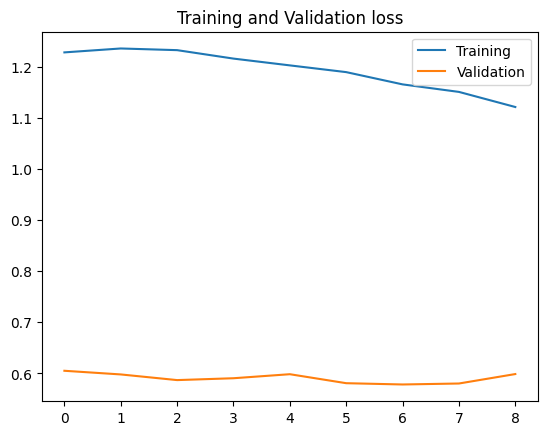

In [14]:
plot_loss(selected_model.train_loss, selected_model.val_loss)

## Test Performance

In [15]:
preds = selected_model.predict(X_test)
test_accuracy = accuracy_score(y_test, preds)

In [16]:
print(f"Test accuracy: {test_accuracy*100:.2f}%")
print(f"Model: {type(selected_model)},\
        learning_rate: {selected_model.learning_rate},\
        epsilon: {selected_model.epsilon},\
        layers: {selected_model.layers if type(selected_model) is not Model1 else ''}")

Test accuracy: 96.67%
Model: <class 'src.Model1'>,        learning_rate: 1.397,        epsilon: 0.473,        layers: 


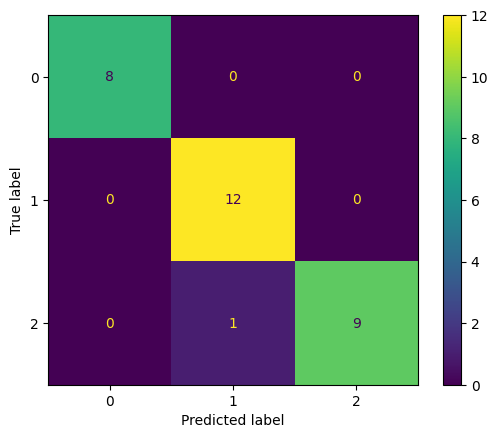

In [17]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.savefig("images/confusion_matrix.png")
plt.show()